## Research Statement
The primary objective of this project is to develop a predictive model for estimating residential property prices based on various housing characteristics. Accurately predicting house prices is a critical task in real estate economics, urban planning, and investment decision-making, as it allows stakeholders to make informed financial choices.

In [79]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import lasso_path
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import datetime

# Set seed
random_state = 42

### Loading and analyzing data

In [80]:
raw_df=pd.read_csv("train.csv")

In [81]:
raw_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [82]:
raw_df.shape

(1460, 81)

In [83]:
raw_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [84]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### MIssing values
checking missing values in data for data cleaning and preprocessing 

<Axes: >

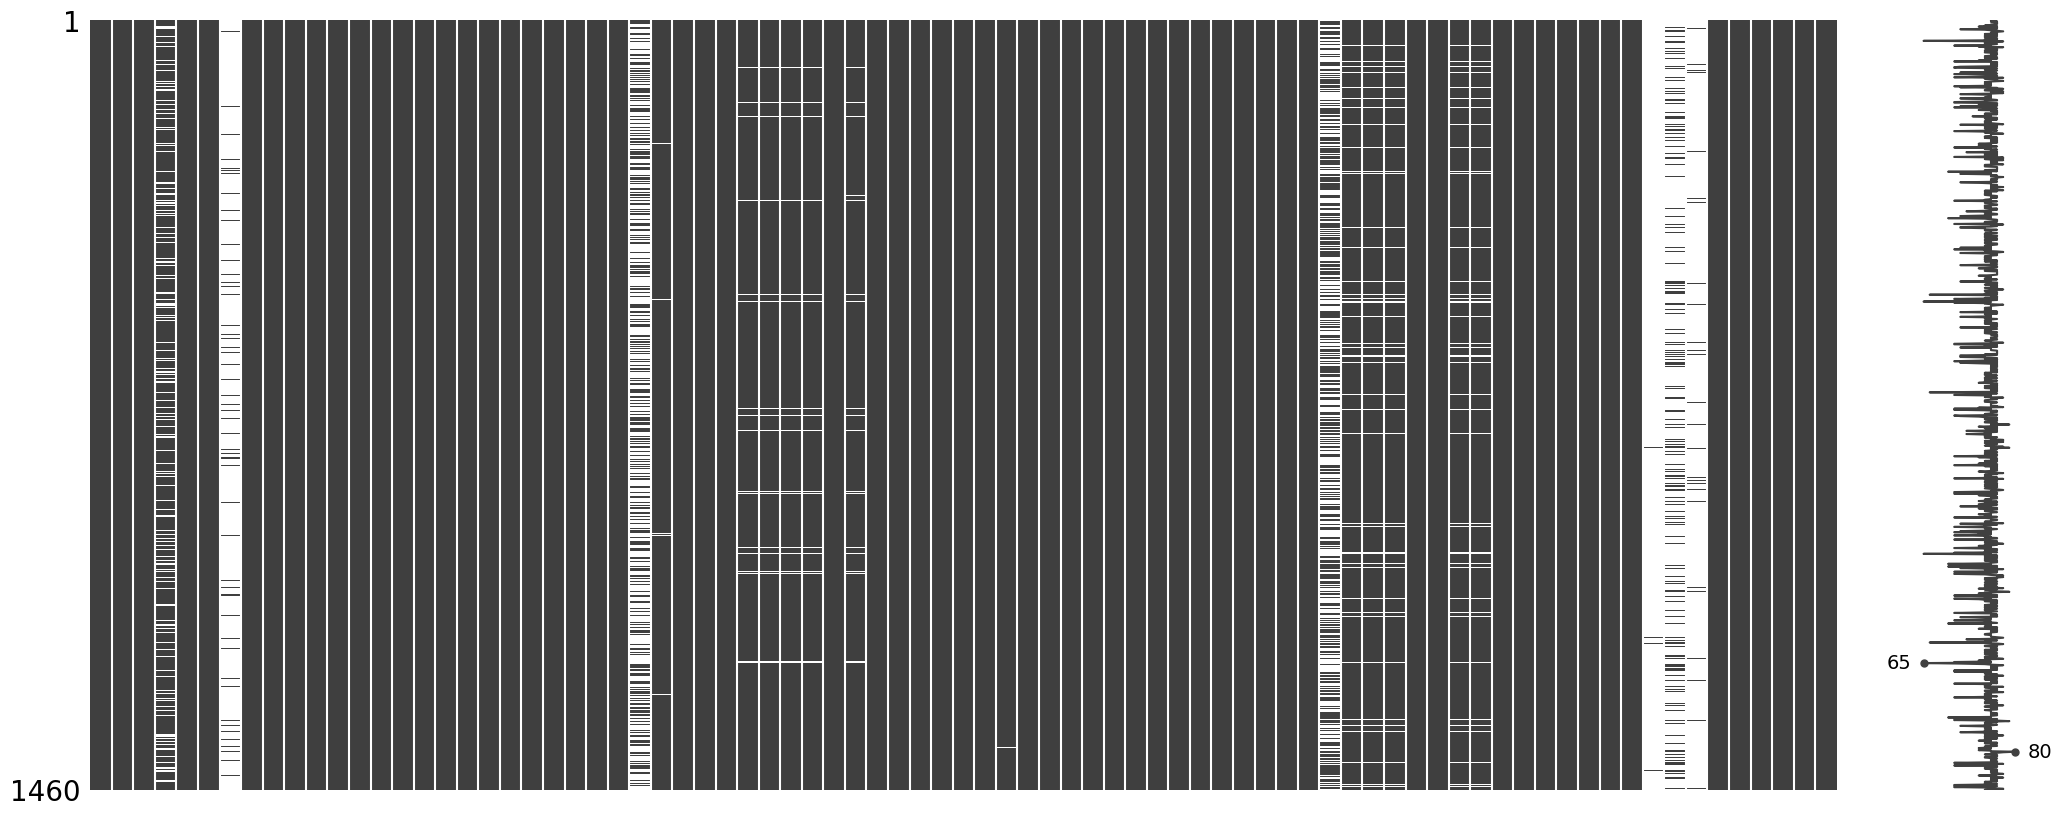

In [85]:
#checking for missing values
# we see missing values in dataset
#description they place N/A in place where pool or alley doesnot exist so we replace these values with 0 
msno.matrix(raw_df)

### Checking unique values 
 checking unique values to see what is in data columns is an important step for data cleaning.

In [86]:

unique_values_dict = {col: raw_df[col].unique() for col in raw_df.columns}

# To see the unique values nicely:
for col, values in unique_values_dict.items():
    print(f"{col}: {values}\n")
    
    


Id: [   1    2    3 ... 1458 1459 1460]

MSSubClass: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]

MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']

LotFrontage: [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]

LotArea: [ 8450  9600 11250 ... 17217 13175  9717]

Street: ['Pave' 'Grvl']

Alley: [nan 'Grvl' 'Pave']

LotShape: ['Reg' 'IR1' 'IR2' 'IR3']

LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']

Utilities: ['AllPub' 'NoSeWa']

LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR

### Data Visualization

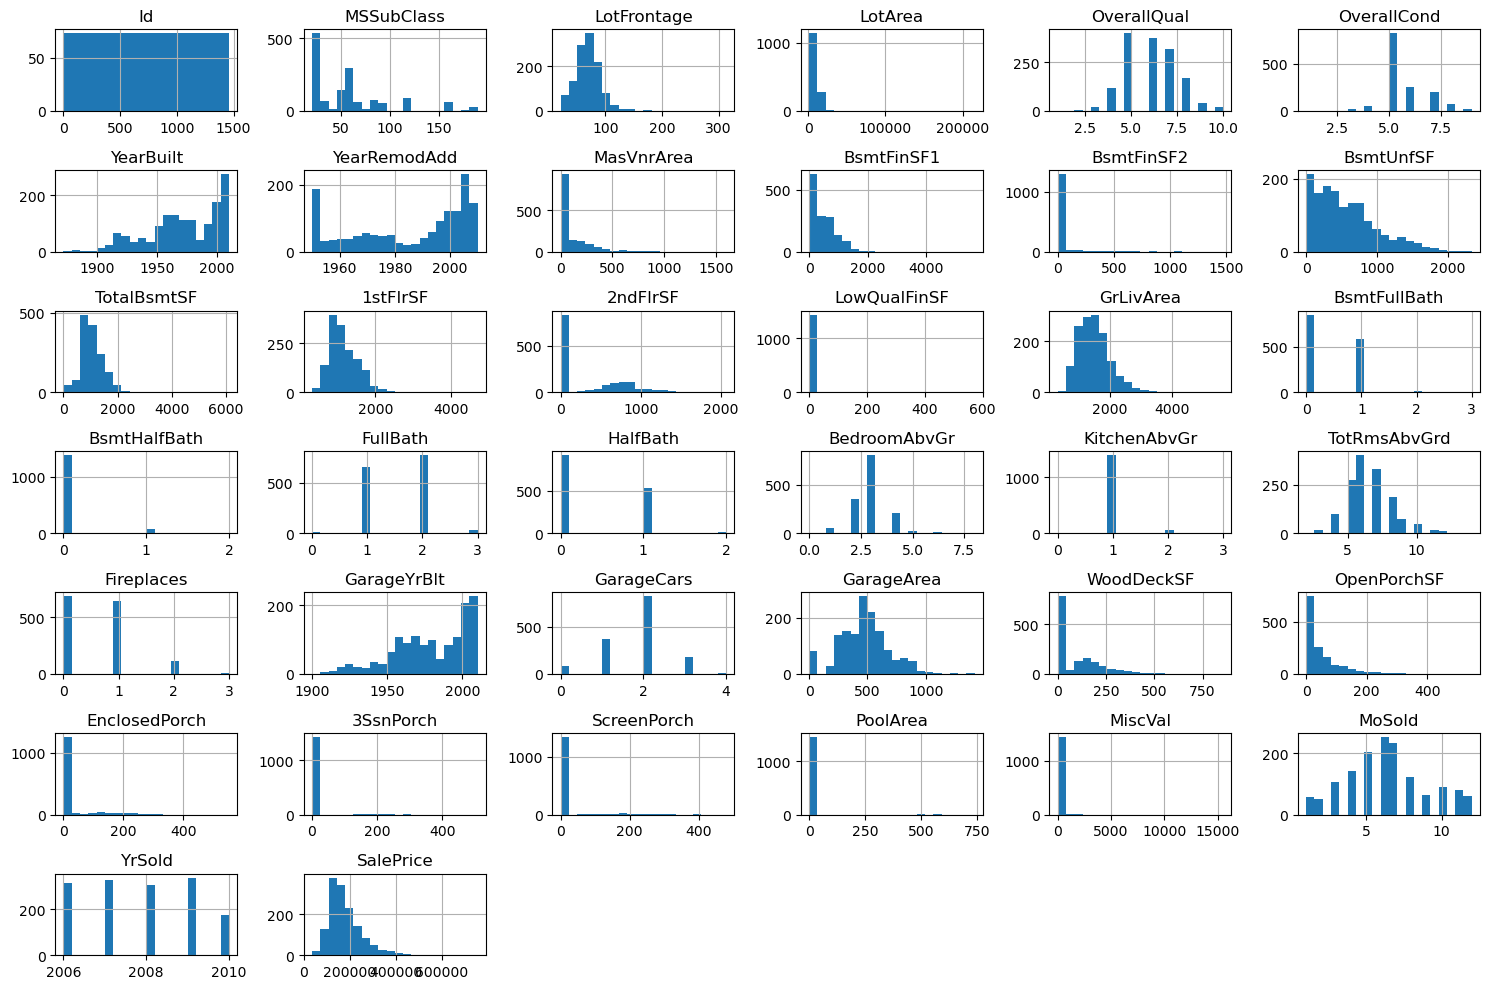

In [87]:
raw_df.hist(bins=20,figsize=(15,10))
plt.tight_layout()
plt.show()

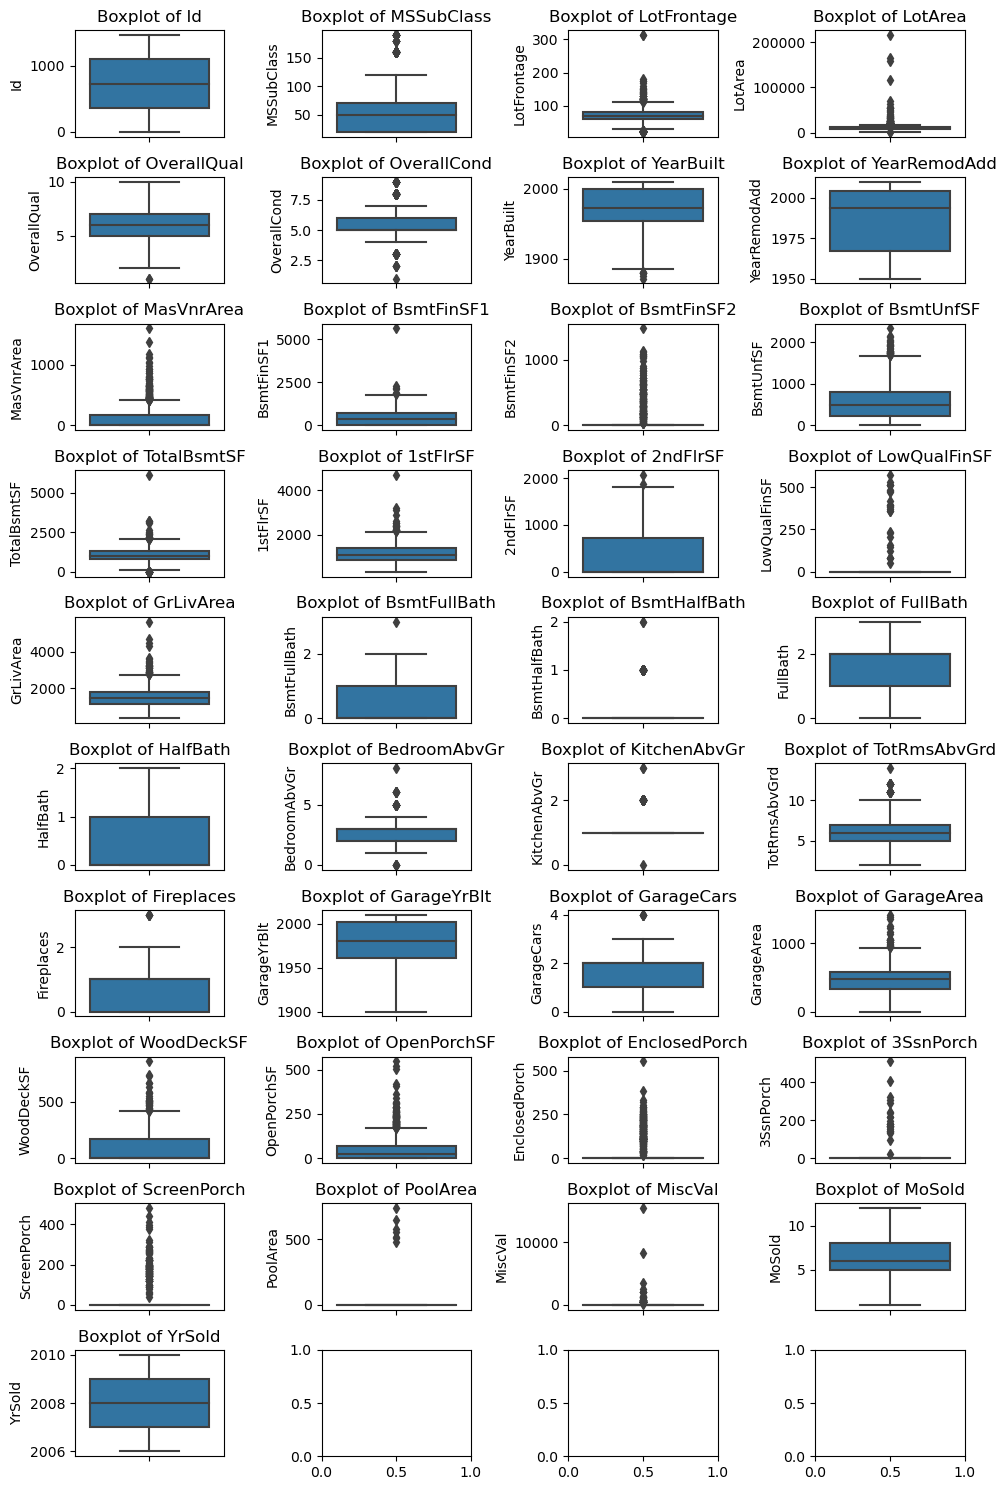

In [88]:
# outliers
fig, axes = plt.subplots(10, 4, figsize=(10, 15))
columns_to_plot = raw_df.select_dtypes(include='number').columns
columns_to_plot =[col for col in columns_to_plot if col not in [ 'SalePrice']]
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.boxplot(data=raw_df, y=col, ax=axes[i])  
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()  # Adjust spacing
plt.show()

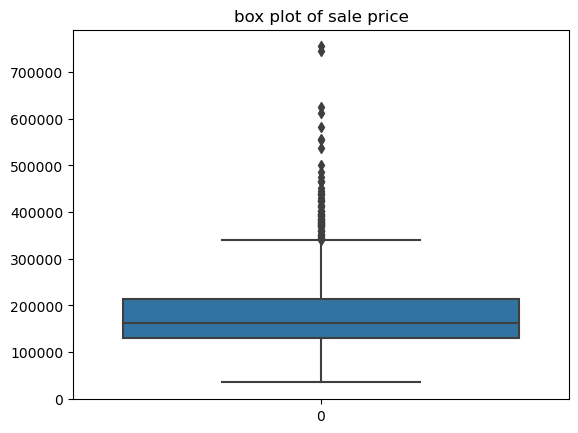

In [89]:
sns.boxplot(raw_df["SalePrice"])
plt.title("box plot of sale price")
plt.show()

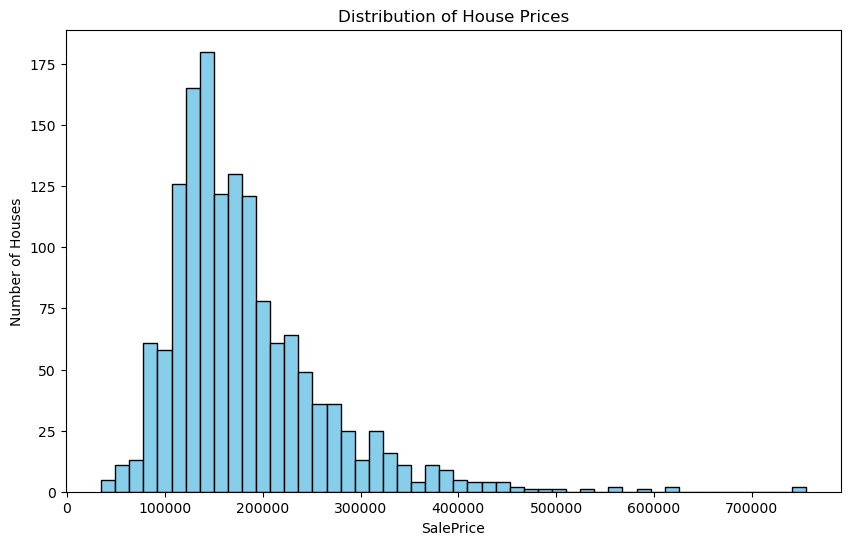

In [90]:
y = raw_df["SalePrice"]

plt.figure(figsize=(10,6))
plt.hist(y, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of House Prices")
plt.xlabel("SalePrice")
plt.ylabel("Number of Houses")
plt.show()


### Deleting columns
deleting columns with extra missing values 
below we show columns which has almost half of values missings so we will drop them 

MiscFeature 54 non-null
FireplaceQu 770 non-null PoolQC 7 non-null
Alley 91 non-null
MasVnrType 588 non-null

​

some columns like ExterQual and external condition share same almost information 
and BsmtFinType2, BsmtFinType1, BsmtExposure, BsmtQual share same almost information
so we will keep one of the columns and delte rest to avoid high coorelation problem
OverallCond, OverallQual
Condition1, Condition2
Exterior1st, Exterior2nd
BsmtFinSF2, 
Bedroom, TotRmsAbvGrd

GarageQual, GarageCond, EnclosedPorch, 3SsnPorch


In [91]:
raw_df.drop(columns=['Id','FireplaceQu','MasVnrType','MiscFeature','PoolQC','Alley','OverallQual','Condition2','Exterior2nd',
                    'Fence', 'BedroomAbvGr' , 'GarageQual','EnclosedPorch', 'ExterQual',
                    'BsmtFinType2', 'BsmtFinType1', 'BsmtExposure'], inplace=True)
raw_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,9,2008,WD,Normal,223500


### Filling missing values
filling missing values as zero because data description said they add N/A when house doesn't have any features

In [92]:

#filling neumeric columns
numeric_cols = raw_df.select_dtypes(include=['int64', 'float64']).columns
raw_df[numeric_cols] = raw_df[numeric_cols].fillna(0)

# filling categorical columns
cat_cols = raw_df.select_dtypes(include=['object']).columns
raw_df[cat_cols] = raw_df[cat_cols].fillna('None')

### Feature engineering
We create house age column by substracting year buit from year remodeled and if house did remodel so we substract year buit from 2025 to calculate house age.

In [93]:
raw_df["HouseAge"] = np.where(
    raw_df["YearRemodAdd"] > 0,
    raw_df["YearRemodAdd"] - raw_df["YearBuilt"],  # if remodeled, age = remodel - built
    2025 - raw_df["YearBuilt"]                     # else, use 2025 as reference
)
raw_df.drop(columns=["YearBuilt", "YearRemodAdd","YrSold"], inplace=True) #dropping columns



### Detecting outliers

In [94]:

Q1 = raw_df["SalePrice"].quantile(0.25)
Q3 = raw_df["SalePrice"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

raw_df_no_outliers = raw_df[
    (raw_df["SalePrice"] <= upper_bound)].copy()

print(f"Original rows: {raw_df.shape[0]}")
print(f"Rows after removing outliers: {raw_df_no_outliers.shape[0]}")



Lower bound: 3937.5, Upper bound: 340037.5
Original rows: 1460
Rows after removing outliers: 1399


### Coorelation Matrix
 Correlation is a statistical measure that expresses the extent to which two variables are linearly related (meaning they change together at a constant rate). It's a common tool for describing simple relationships without making a statement about cause and effect. Checking coorelation between variables is crucial step towards modeling because high correlation between independent variables, causes problems in modeling by making it difficult to determine the true effect of each variable, leading to less reliable predictions and poor generalization to new data. It increases model variance and can cause overfitting, making the model perform poorly on unseen data because it's unstable and can give undue importance to correlated predictors. 

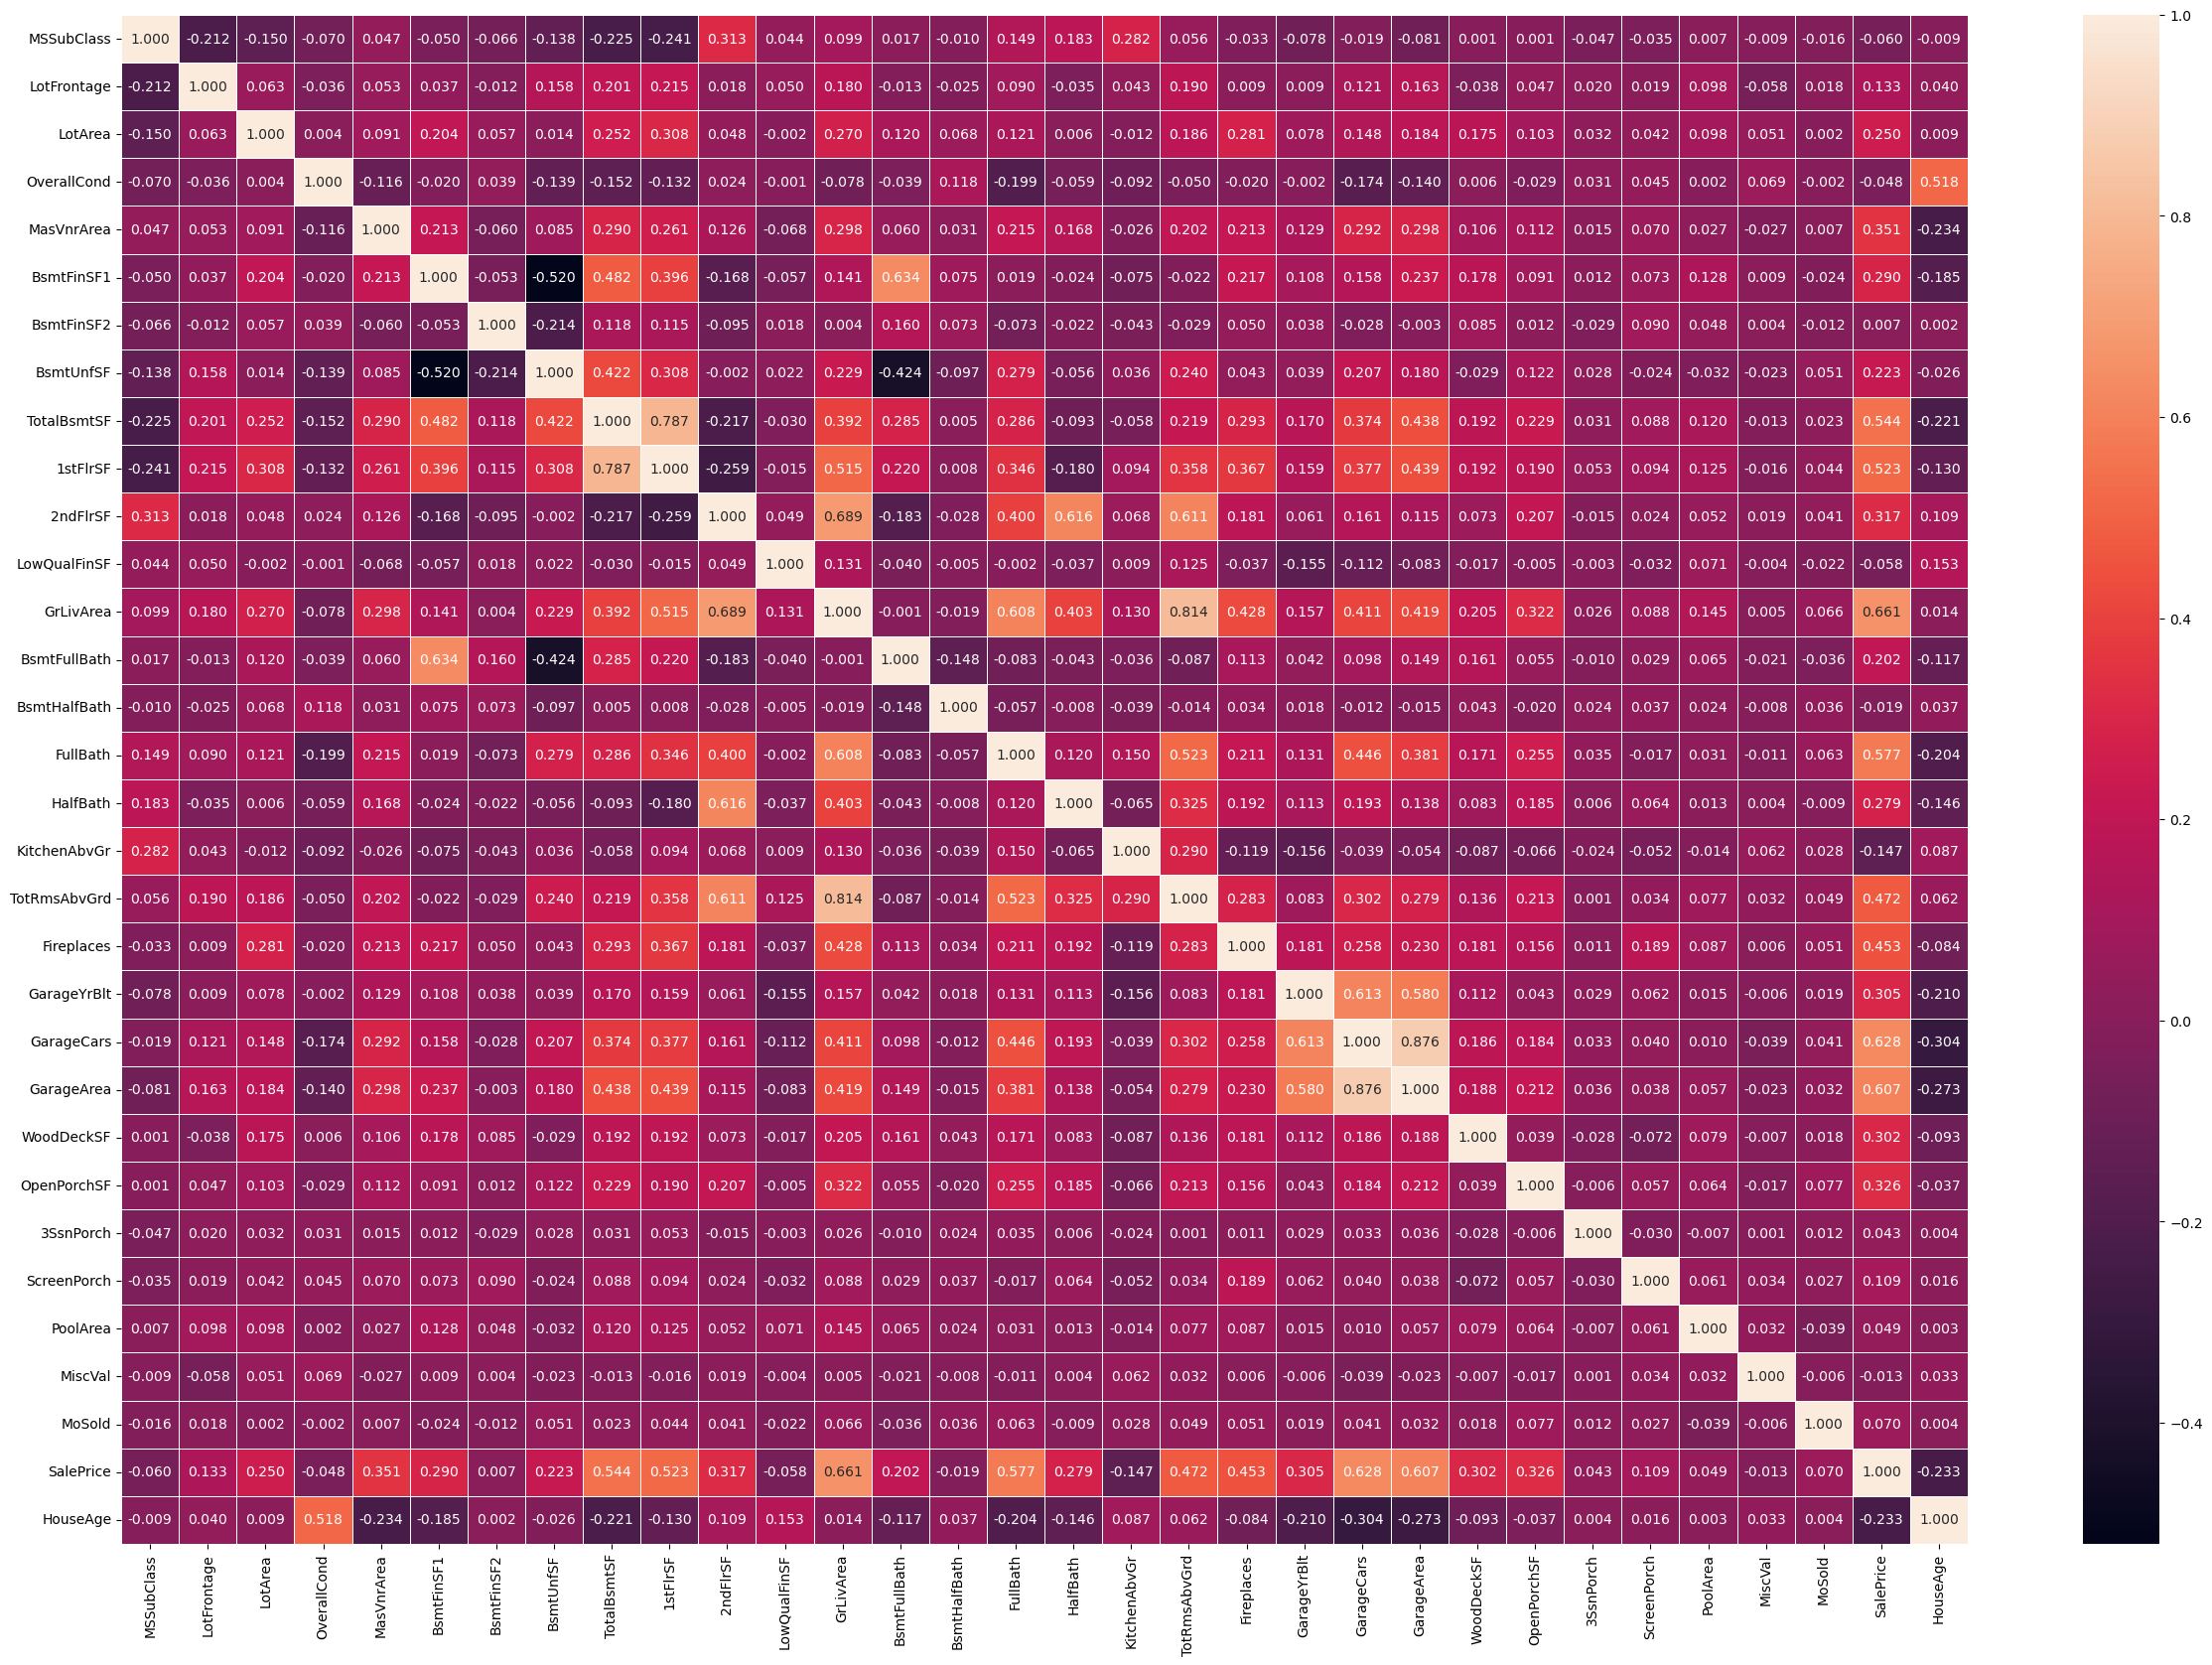

In [95]:
corr_matrix = raw_df_no_outliers.select_dtypes(include='number').corr()

plt.figure(figsize=[30, 20])
sns.heatmap(corr_matrix,annot=True,linewidth=.5,fmt='.3f')
plt.show()

### checking for coorealation between variables and deleting them

In [96]:
# Taking absolute correlation values
corr_matrix_abs = corr_matrix.abs()

# Removing self-correlation (diagonal = 1)
np.fill_diagonal(corr_matrix_abs.values, 0)

# Finding pairs above a threshold (e.g., 0.5)
high_corr = np.where(corr_matrix_abs > 0.5)

# Printing feature pairs
for i, j in zip(*high_corr):
    if i < j:  # avoid duplicates
        print(f"{corr_matrix_abs.index[i]} and {corr_matrix_abs.columns[j]}: {corr_matrix_abs.iat[i,j]:.2f}")


OverallCond and HouseAge: 0.52
BsmtFinSF1 and BsmtUnfSF: 0.52
BsmtFinSF1 and BsmtFullBath: 0.63
TotalBsmtSF and 1stFlrSF: 0.79
TotalBsmtSF and SalePrice: 0.54
1stFlrSF and GrLivArea: 0.51
1stFlrSF and SalePrice: 0.52
2ndFlrSF and GrLivArea: 0.69
2ndFlrSF and HalfBath: 0.62
2ndFlrSF and TotRmsAbvGrd: 0.61
GrLivArea and FullBath: 0.61
GrLivArea and TotRmsAbvGrd: 0.81
GrLivArea and SalePrice: 0.66
FullBath and TotRmsAbvGrd: 0.52
FullBath and SalePrice: 0.58
GarageYrBlt and GarageCars: 0.61
GarageYrBlt and GarageArea: 0.58
GarageCars and GarageArea: 0.88
GarageCars and SalePrice: 0.63
GarageArea and SalePrice: 0.61


In [97]:
raw_df_no_outliers.drop(columns=['GarageYrBlt'],inplace=True)

In [98]:
raw_df_no_outliers.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,HouseAge
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,2,WD,Normal,208500,0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,WD,Normal,181500,0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,9,WD,Normal,223500,1
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,0,0,0,0,2,WD,Abnorml,140000,55
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,12,WD,Normal,250000,0


### Data Encoding
Data encoding is used to make categorical data compatible with machine learning algorithms by converting it into a numerical, binary format, preventing algorithms from misinterpreting implicit ordinal relationships (e.g., 1 < 2 < 3) when none exist. This approach enhances model performance by providing a consistent distance representation between categories and simplifies input for algorithms that require numerical features. In our data we see variables like Gd,Av,Mn,No,NA so we need to convert them in simple integers/float to make it easy for machine learning variables.
       

In [99]:
raw_df_encoded  =pd.get_dummies(raw_df_no_outliers, columns=raw_df_no_outliers.select_dtypes(include=['object']).columns, dtype=int, drop_first=True)

In [100]:
raw_df_encoded.head(10)

,MSSubClass,LotFrontage,LotArea,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,5,196.0,706,0,150,856,856,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,8,0.0,978,0,284,1262,1262,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,5,162.0,486,0,434,920,920,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,5,0.0,216,0,540,756,961,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,5,350.0,655,0,490,1145,1145,...,0,0,0,0,1,0,0,0,1,0
5,50,85.0,14115,5,0.0,732,0,64,796,796,...,0,0,0,0,1,0,0,0,1,0
6,20,75.0,10084,5,186.0,1369,0,317,1686,1694,...,0,0,0,0,1,0,0,0,1,0
7,60,0.0,10382,6,240.0,859,32,216,1107,1107,...,0,0,0,0,1,0,0,0,1,0
8,50,51.0,6120,5,0.0,0,0,952,952,1022,...,0,0,0,0,1,0,0,0,0,0
9,190,50.0,7420,6,0.0,851,0,140,991,1077,...,0,0,0,0,1,0,0,0,1,0


### Checking vif to see if there is still coorelation between variables

In [101]:
X=raw_df_encoded.drop(columns=["SalePrice"])
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

C:\Users\Hina\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                   feature        VIF
0               MSSubClass  88.448836
1              LotFrontage   6.192009
2                  LotArea   6.856084
3              OverallCond  61.099920
4               MasVnrArea   2.267564
..                     ...        ...
182  SaleCondition_AdjLand   1.519929
183   SaleCondition_Alloca   1.637996
184   SaleCondition_Family   1.397910
185   SaleCondition_Normal  18.189572
186  SaleCondition_Partial  39.264621

[187 rows x 2 columns]


In [102]:
# Drop features with very high multicollinearity or redundancy
drop_cols = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "LowQualFinSF","GarageArea", "GarageType_None", "GarageFinish_None",
             "GarageCond_None","BsmtQual_None", "BsmtCond_None","MSZoning_RL", "RoofStyle_Gable", "RoofMatl_CompShg",
             "ExterCond_TA", "Heating_GasA", "GarageCond_TA","Functional_Typ", "GarageType_Attchd", "MSSubClass", "OverallCond", 
             "KitchenAbvGr", "TotRmsAbvGrd", "FullBath"]


raw_df_encoded = raw_df_encoded.drop(
    columns=[c for c in drop_cols if c in raw_df_encoded.columns],
    axis=1
)


In [103]:
raw_df_encoded.shape

(1399, 165)

### Data Modeling


In [104]:
#assigning x values
X_new=raw_df_encoded.drop(columns=["SalePrice"])
#assigning y values, applied log transformation to y as "Sale price" data is skewed and can see in graph easily
y=np.log1p(raw_df_encoded["SalePrice"].values)
 

In [105]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X=scaler.fit_transform(X_new)

In [106]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42, test_size=0.2)

### Lasso Regression

In [107]:
from sklearn.linear_model import LassoCV
lasso_reg=LassoCV(max_iter=1000, cv=5, random_state=42)
lasso_reg.fit(X_train,y_train)


LassoCV(cv=5, random_state=42)

In [108]:
y_train_pred=lasso_reg.predict(X_train)
y_test_pred=lasso_reg.predict(X_test)
# RMSE function
from sklearn.metrics import mean_squared_error, r2_score
rmse_train=np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test=np.sqrt(mean_squared_error(y_test, y_test_pred))
# Training evaluation
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train R2:", r2_score(y_train, y_train_pred))

# Test evaluation
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Test R2:", r2_score(y_test, y_test_pred))

Train RMSE: 0.13398587112373844
Train R2: 0.8608419352911227
Test RMSE: 0.14005793073367856
Test R2: 0.8304127148468528


### Best alpha and model evaluation

In [109]:
print("Best alpha chosen by LassoCV:", lasso_reg.alpha_)

Best alpha chosen by LassoCV: 0.003579719233824299


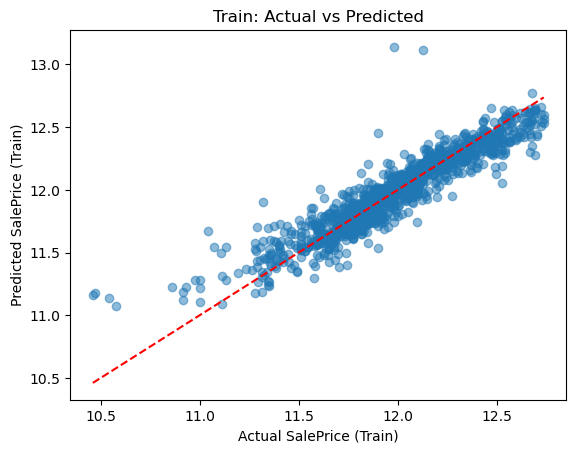

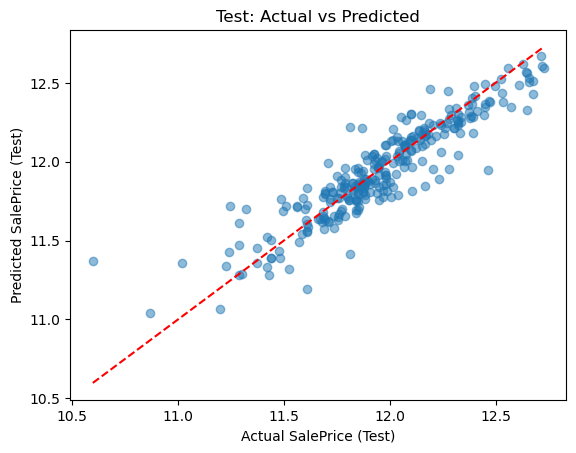

In [110]:
#Actual vs predicted scatter plot

# Train plot
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual SalePrice (Train)")
plt.ylabel("Predicted SalePrice (Train)")
plt.title("Train: Actual vs Predicted")
plt.show()

# Test plot
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual SalePrice (Test)")
plt.ylabel("Predicted SalePrice (Test)")
plt.title("Test: Actual vs Predicted")
plt.show()


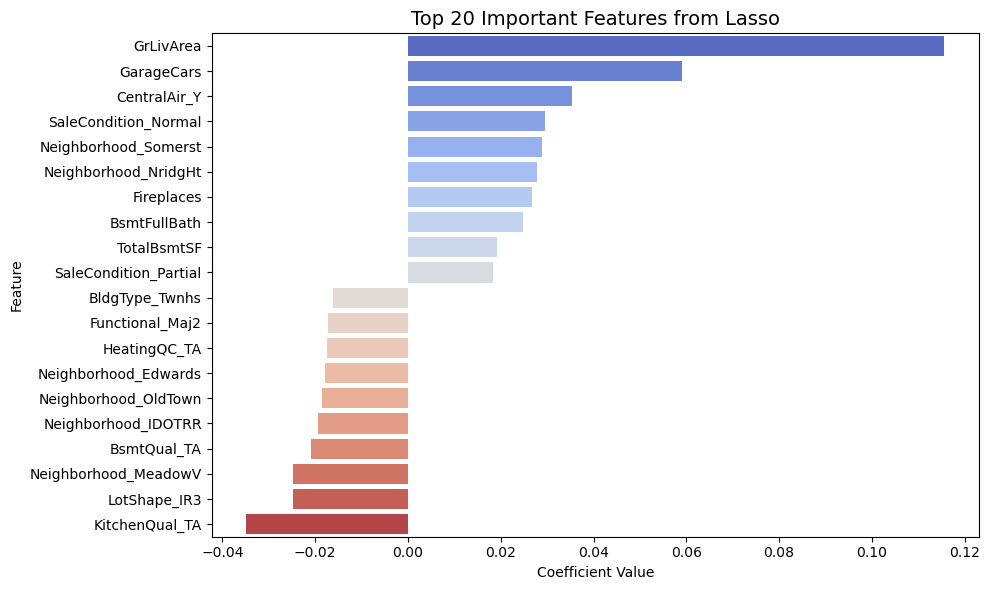

In [111]:


# If you still have the original encoded DataFrame with column names:
feature_names = raw_df_encoded.drop(columns=["SalePrice"]).columns  

# Now map coefficients to feature names
coef = pd.Series(lasso_reg.coef_, index=feature_names)
coef=coef.sort_values(ascending=False)
top_coef=pd.concat([coef.head(10), coef.tail(10)])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_coef.values, y=top_coef.index, palette="coolwarm")
plt.title("Top 20 Important Features from Lasso", fontsize=14)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



### XGBOOST REGRESSOR

In [112]:

# Base model
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Parameter grid (search space)
param_dist = {
    "n_estimators": [200, 500, 800, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5, 6, 8],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0.1, 1, 5, 10]
}


In [113]:
# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,                 # number of parameter sets to try
    scoring="neg_root_mean_squared_error",  # RMSE
    cv=5,                      # 5-fold cross validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score (RMSE):", -random_search.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best CV Score (RMSE): 0.13693918940664793


In [114]:
# Best estimator
best_xgb = random_search.best_estimator_

# Predictions
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")


Train RMSE: 0.0103, R2: 0.9992
Test  RMSE: 0.1394, R2: 0.8320


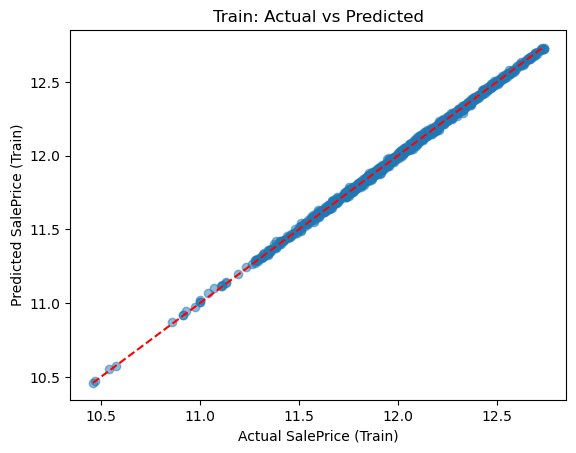

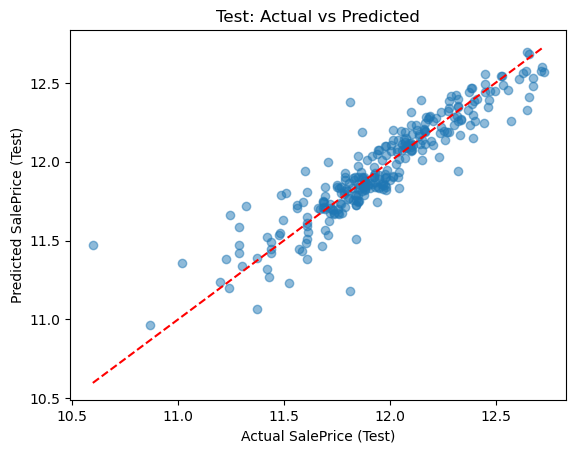

In [115]:
# Train plot
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual SalePrice (Train)")
plt.ylabel("Predicted SalePrice (Train)")
plt.title("Train: Actual vs Predicted")
plt.show()

# Test plot
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual SalePrice (Test)")
plt.ylabel("Predicted SalePrice (Test)")
plt.title("Test: Actual vs Predicted")
plt.show()


### Summary

Results from Lasso Regression
Train RMSE: 0.134
Train R2: 0.86
Test RMSE: 0.14
Test R2: 0.83

Results from XGBoost
Train RMSE: 0.0103, 
Train R2: 0.9992
Test  RMSE: 0.1394, 
Train R2: 0.8320
Both models perform well XGBoost overfitted but still shows good results the model we select will depend on our use case in this scenario